In [1]:
%matplotlib inline
import re
import cairo
import cv2
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (20, 10)

Napisz program, który przy pomocy Cairo generuje plik z rysunkiem krzywej sklejanej Catmulla-Roma ze zduplikowanymi krańcowymi punktami kontrolnymi. Współrzędne punktów kontrolnych wczytywane są z pliku, w którym każda linia zawiera dwie liczby odpowiadające współrzędnym X i Y.

Oprócz nazwy pliku z danymi programowi podaje się również nazwę pliku wynikowego. Jeśli jego rozszerzeniem jest .png, to program powinien wygenerować obrazek w tym formacie, mający 1024 kolumny i 768 wierszy. Dla rozszerzenia .pdf generowany plik powinien mieć wymiary 16 na 9 centymetrów. (Uprzedzając ewentualne pytanie: tak, obrazy 1024x768 i 16x9 mają inne proporcje, to nie jest pomyłka w treści zadania.) Dla innych rozszerzeń program powinien zgłosić błąd.

Cairo nie ma funkcji służących do rysowania krzywych Hermite’a, ale ma funkcję do rysowania kubicznych krzywych Béziera. A ponieważ oba te typy krzywych to wielomianowe krzywe parametryczne trzeciego rzędu, to można dokonać konwersji, czyli dla danej krzywej wyliczyć opisujące ją współrzędne punktów kontrolnych Béziera na podstawie współrzędnych punktów i wektorów kontrolnych Hermite’a. Główna pętla programu powinna więc działać tak: wylicz punkty i wektory dla bieżącego segmentu krzywej sklejanej, skonwertuj, wywołaj funkcję curve_to, przejdź do następnego segmentu.

Wczytywane z pliku współrzędne są bezwymiarowe i mogą przyjmować dowolne wartości. Oznacza to, że przed przystąpieniem do rysowania trzeba najpierw obliczyć przedziały, w których zawierają się iksy oraz igreki, a potem na tej podstawie wyliczyć odpowiednią transformację współrzędnych. Narysowana krzywa musi być w całości widoczna na obrazku. Po bokach należy pozostawić puste marginesy szerokości / wysokości co najmniej 1% szerokości / wysokości obrazka.

Kod źródłowy programu musi być przejrzysty i zawierać komentarze wyjaśniające znaczenie wykonywanych obliczeń. Uwaga: jeśli w kodzie jest instrukcja x = 0.5 * x, to komentarz w stylu „mnożymy x przez 50%” zostanie przeze mnie uznany za bezużyteczny. Każdy programista to przecież widzi patrząc na instrukcję. To, co jest potrzebne, to komentarze wyjaśniające skąd się to 50% wzięło i co sobą reprezentuje.

In [2]:
def scale_points(width, height, points):
    x_list = []
    y_list = []

    for x, y in points:
        x_list.append(x)
        y_list.append(y)

    # skalowanie punktów do 90% obszaru obrazka (1024 x 768)
    x_scaling = (width  / max(x_list)) * 0.9
    y_scaling = (height / max(y_list)) * 0.9

    return [(x * x_scaling, y * y_scaling) for x, y in points]

In [3]:
def draw_bezier(context, points):
    ctx.set_source_rgb(0, 1, 0)
    
    # ustaw rysowanie na pierwszym punkcie
    context.move_to(points[0][0] , points[0][1])
    
    # podziel tablice punktow na segmenty po 3 punkty
    for chunk in np.array_split(points[1:], len(points) / 3): 
        ax = chunk[0][0] 
        ay = chunk[0][1]
        bx = chunk[1][0]
        by = chunk[1][1] 
        cx = chunk[2][0] 
        cy = chunk[2][1] 

        # pociagnij segment do punktu c z kontrolkami a i b
        context.curve_to(ax, ay, bx, by, cx, cy) 
    # rysowanie
    context.stroke() 

![Catmull rom points to bezier](https://i.imgur.com/7FIIZ82.png)

In [4]:
def draw_catmull_rom(context, data_points, tension):
    ctx.set_source_rgb(1, 0, 0)
    
    # ustaw pierwszy punkt
    p0_x = data_points[0][0]
    p0_y = data_points[0][1]
    ctx.move_to(p0_x, p0_y)
    
    # Konwertowanie punktów catmulla rom na beziera. 
    # Od zakresu petli odejmujemy 3 poniewaz: 
    # 1: aby nie wykroczyc poza zakres len 
    # 2: za 2 dodane punkty boczne
    for i in range(len(data_points) - 3):
        p1_x = data_points[i + 1][0] + (data_points[i + 2][0] - data_points[i][0]) / (6 * tension)
        p1_y = data_points[i + 1][1] + (data_points[i + 2][1] - data_points[i][1]) / (6 * tension)
        p2_x = data_points[i + 2][0] - (data_points[i + 3][0] - data_points[i + 1][0]) / (6 * tension)
        p2_y = data_points[i + 2][1] - (data_points[i + 3][1] - data_points[i + 1][1]) / (6 * tension)
        p3_x = data_points[i + 2][0]
        p3_y = data_points[i + 2][1]

        context.curve_to(p1_x, p1_y, p2_x, p2_y, p3_x, p3_y)

    context.stroke()

In [5]:
def prepare_catmull_points(points):
    bezierPoints = points.copy()
    
    # kopiujemy pierwszy i ostatni punkty kontrolny, aby skleic splajn od pierwszego do ostatniego punktu
    bezierPoints.insert(0, points[0])
    bezierPoints.append(points[-1])
    
    return bezierPoints

In [6]:
def load_points_from_file(filename):
    data_file_pattern = re.compile(r'(\d+) (\d+)$')
    points = []
    with open('points.txt','r') as f:
        while True:
            line = f.readline()

            match = data_file_pattern.match(line)
            if match is None:
                break

            (x, y) = map(int, match.groups())
            points.append((x, y))
            
    if len(points) < 2:
        raise ValueError("At least 2 points must be specified")
        
    return points

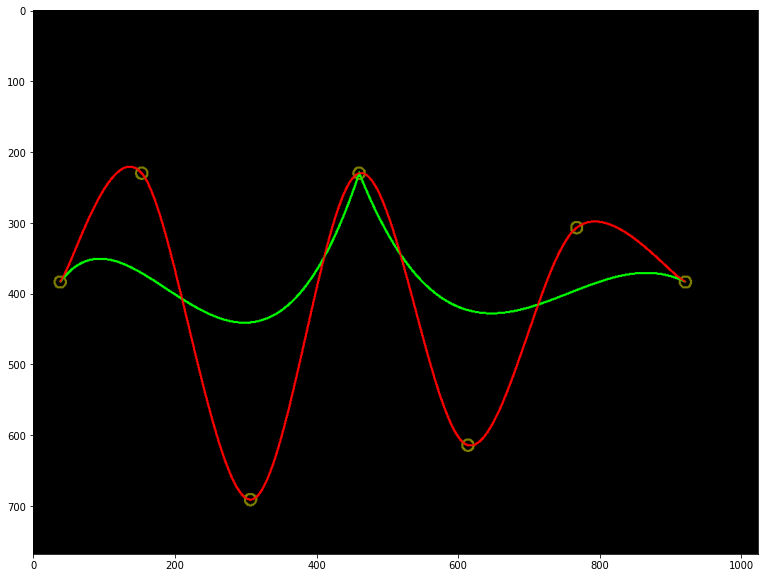

In [7]:
width = 1024
height = 768

surf = cairo.SVGSurface("wynik.svg", width, height)
ctx = cairo.Context(surf)
ctx.set_line_width(2)

points = load_points_from_file('points.txt')    
points_scaled = scale_points(width, height, points)

# Rysowanie punktów na obrazku
ctx.set_source_rgb(0.5, 0.5, 0)
for x, y in points_scaled:
    ctx.arc(x , y, 8, 0.0, 6.283)    # ciut mniej niż 2π
    ctx.close_path()
    ctx.stroke()

# Do beziera potrzebujemy minimum 4 punktów. Gdy punktów jest wiecej niz 4, 
# odejmujemy 1 (pierwszy punkt ktory ustawiamy) oraz sprawdzamy czy jest wielokrotnoscia 3:
# (2 punkty kontrolne oraz 1 do którego dobiegamy)
if len(points) >= 4 and (len(points) - 1) % 3 == 0:
    draw_bezier(ctx, points_scaled)

catmull_points = prepare_catmull_points(points_scaled)
draw_catmull_rom(ctx, catmull_points, 1.0)

surf.write_to_png("wynik.png")
img = cv2.imread("wynik.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))